# Rekomendacje filmów
## Spis treści:
* 1 [Wstęp](#_1)
* 2 [Testy](#_2)
* 3 [Wczytanie danych](#_3)
* 4 [Eksploracja zbioru](#_4)
    * 4.1 [10 gatunków filmowych z największą liczbą produkcji](#_4_1)
    * 4.2 [10 najczęściej ocenianych gatunków filmowych](#_4_2)
    * 4.3 [10 najlepiej ocenianych gatunków filmowych](#_4_3)
* 5 [Rekomendacje](#_5)

<a id='_1'></a>
## 1. Wstęp
Chyba każdy lubi spędzić od czasu do czasu wieczór na oglądaniu dobrego filmu. Zwłaszcza jesienią, kiedy wieczory stają się coraz dłuższe. Problem w tym, że żeby go obejrzeć, trzeba go najpierw znaleźć i tu pojawia się pomysł na stworzenie systemu rekomendacji.<br>
Rekomendacje stworzono z wykorzystaniem zbioru [movielens](https://grouplens.org/datasets/movielens/). Zawiera on 27 tysięcy filmów, w stosunku do których 138 tysięcy użytkowników wystawiło w sumie 20 milionów ocen. 

<a id='_2'></a>
## 2. Testy
Aby uniknąć dość kosztownych czasowo błędów, zastosowano testy. Takie rozwiązanie oszczędza moc obliczeniową dzięki sprawdzeniu poprawności na kilku rekordach zamiast np. na kilku milionach. Ułatwia także wprowadzanie zmian, ponieważ od razu dostarcza informacji, który element potoku zachowuję się nieprawidłowo.<br> Podczas tworzenia testów wykorzystano informacje znajdujące się w [artykule](https://engblog.nextdoor.com/unit-testing-apache-spark-with-py-test-3b8970dc013b).

In [1]:
import ipytest
ipytest.run_pytest(filename='tests.py');

============================= test session starts ==============================
platform linux -- Python 3.5.4, pytest-3.8.0, py-1.6.0, pluggy-0.7.1
rootdir: /home/wojciech/Data Science/Portfolio/Rekomendacje, inifile:
collected 10 items

tests.py ..........                                                      [100%]

========================== 10 passed in 18.09 seconds ==========================


<a id='_3'></a>
## 3. Wczytanie danych

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark import StorageLevel
from pyspark.sql.functions import lower,col
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
spark = SparkSession.builder.appName('Rekomendacje').getOrCreate()
sc = spark.sparkContext

In [4]:
df_movies = spark.read.csv('../../../BigInput/ml-20m/movies.csv',
                   header=True,inferSchema=True)

In [5]:
df_movies.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [6]:
df_movies.limit(5).toPandas()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
df_ratings = spark.read.csv('../../../BigInput/ml-20m/ratings.csv',
                   header=True,inferSchema=True)

In [8]:
df_ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [9]:
df_ratings.limit(5).toPandas()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [10]:
# %load spark_functions.py
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import spatial
from pyspark.sql.functions import lower, col


def split_genres(rdd):
    return rdd.map(lambda x: (x.movieId, x.genres)) \
        .keyBy(lambda x: x[0]) \
        .mapValues(lambda x: x[1].lower().split('|')) \
        .flatMapValues(lambda x: x)


def count_genres(rdd):
    return rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b)


def ratings_stats(rdd_genres, rdd_ratings):
    return rdd_genres.join(rdd_ratings.map(lambda x: (x.movieId, x.rating))) \
        .map(lambda x: (x[1][0], (x[1][1], 1))) \
        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
        .map(lambda x: (x[0],*x[1], x[1][0] / x[1][1]))


def contains_element(x, titles):
    for title in titles.value:
        if title[0] in x:
            return title[1]
    return None


def get_films_ids(df, titles):
    return df.withColumn('title_lower', lower(col('title'))) \
        .rdd.map(lambda x: (x.movieId, x.title_lower)) \
        .map(lambda x: (x[0], contains_element(x[1], titles))) \
        .filter(lambda x: x[1])


def ratings_similarity_MSE(l, d, v):
    result = np.zeros(len(d.value))
    for movieId, rating in l:
        result[d.value[movieId]] = rating
    return mean_squared_error(result, v.value)


def ratings_similarity_COS(l, d, v):
    result = np.zeros(len(d.value))
    for movieId, rating in l:
        result[d.value[movieId]] = rating
    sim = 1 - spatial.distance.cosine(result, v.value)
    return 2 / (1 / sim + 1 / len(l))


def get_similarity(rdd, db, vb, ids, top=10, similarity_function=ratings_similarity_MSE):
    return rdd.filter(lambda x: x.movieId in ids.value) \
        .map(lambda x: (x.userId, [(x.movieId, x.rating)])) \
        .reduceByKey(lambda a, b: a + b) \
        .mapValues(lambda x: similarity_function(x, db, vb)) \
        .takeOrdered(top, key=lambda x: x[1])


def harmonic(a, b):
    return 2 / (1 / a + 1 / b)


def get_films_stats(rdd_users, rdd_ratings, seen_films_id, top=10):
    tmp = rdd_ratings.filter(lambda x: x.movieId not in seen_films_id.value) \
        .keyBy(lambda x: x.userId) \
        .mapValues(lambda x: (x.movieId, x.rating))
    return rdd_users.join(tmp) \
        .map(lambda x: x[1][1]) \
        .mapValues(lambda x: (x, 1)) \
        .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
        .mapValues(lambda x: (x[0] / x[1], x[1])) \
        .mapValues(lambda x: (*x, harmonic(x[0], x[1]))) \
        .top(top, key=lambda x: x[1][2])


def get_recommendations(rdd_films_stats, rdd_films):
    columns = ['rating', 'users_seen', 'f_score', 'title', 'genres']
    rdd_films_data = rdd_films.map(lambda x: (x.movieId, (x.title, x.genres)))
    return rdd_films_stats.join(rdd_films_data) \
        .map(lambda x: (*x[1][0], *x[1][1])) \
        .toDF(columns).orderBy('f_score', ascending=False)


def recommendations_pipe(sc, df_movies, df_ratings, titles, n_top_users=10,
                         n_top_films=10, similarity_function=ratings_similarity_MSE):
    titles_b = sc.broadcast(titles)
    ids_and_ratings = get_films_ids(df_movies, titles_b).collect()
    titles_b.unpersist()
    ids, ratings = zip(*ids_and_ratings)
    positions_b = sc.broadcast({k: v for v, k in enumerate(ids)})
    ratings_b = sc.broadcast(ratings)
    seen_films_id_b = sc.broadcast(ids)
    top_user = get_similarity(df_ratings.rdd, positions_b, ratings_b, seen_films_id_b,
                              n_top_users, similarity_function)
    ratings_b.unpersist()
    positions_b.unpersist()
    rdd_users = sc.parallelize(top_user)
    films_stats = get_films_stats(rdd_users, df_ratings.rdd, seen_films_id_b, n_top_films)
    seen_films_id_b.unpersist()
    rdd_films_stats = sc.parallelize(films_stats)
    return get_recommendations(rdd_films_stats, df_movies.rdd)


<a id='_4'></a>
## 4. Eksploracja zbioru

<a id='_4_1'></a>
### 4.1. 10 gatunków filmowych z największą liczbą produkcji

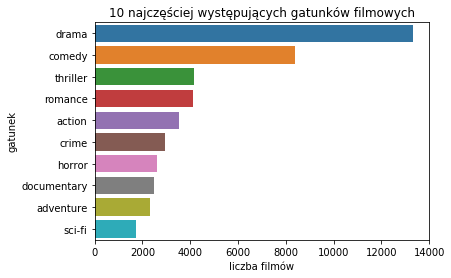

In [11]:
s_genres = split_genres(df_movies.rdd)
s_genres.persist()
genres_count = count_genres(s_genres)
df_genres = genres_count.toDF(['genre','count']).orderBy('count',ascending=False).toPandas()
sns.barplot(x='count',y='genre',data=df_genres.head(10))
plt.title('10 najczęściej występujących gatunków filmowych')
plt.xlabel('liczba filmów')
plt.ylabel('gatunek');

<a id='_4_2'></a>
### 4.2. 10 najczęściej ocenianych gatunków filmowych

In [12]:
popular_genres = ratings_stats(s_genres,df_ratings.rdd)

In [13]:
df_popular_genres = popular_genres\
    .toDF(['genre','rating_sum','rating_num','rating_mean'])\
    .orderBy('rating_num',ascending=False).toPandas()
s_genres.unpersist()

PythonRDD[30] at RDD at PythonRDD.scala:49

In [14]:
top = 10
rating_num_mln = df_popular_genres.head(top).rating_num/1000000

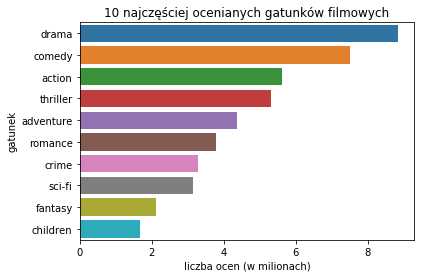

In [15]:
sns.barplot(x=rating_num_mln,y=df_popular_genres.head(top).genre)
plt.title('10 najczęściej ocenianych gatunków filmowych')
plt.xlabel('liczba ocen (w milionach)')
plt.ylabel('gatunek');

<a id='_4_3'></a>
### 4.3. 10 najlepiej ocenianych gatunków filmowych

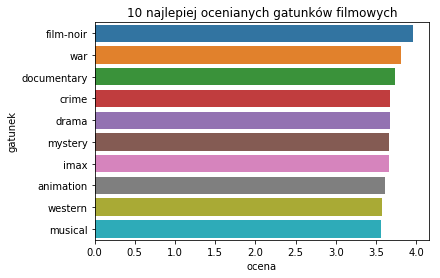

In [16]:
sns.barplot(x='rating_mean',y='genre',
            data=df_popular_genres.sort_values('rating_mean',ascending=False)\
            .head(top))
plt.title('10 najlepiej ocenianych gatunków filmowych')
plt.xlabel('ocena')
plt.ylabel('gatunek');

<a id='_5'></a>
## 5. Rekomendacje

Serwisy zajmujące się generowaniem rekomendacji zwykle sprawdzają wzajemne podobieństwo wszystkich użytkowników względem siebie. Następnie wyniki są zapisywane i wykorzystywane aż do aktualizacji podobieństw. Dzięki takiemu podejściu np. strona internetowa odpytywana o rekomendację zwraca ją natychmiast bez dodatkowych obliczeń. <br>
Zawarty tutaj system sprawdza podobieństwo pomiędzy daną listą filmów wraz z ocenami a preferencjami użytkowników. Zaletą takie podejścia jest możliwość wygenerowania rekomendacji na komputerze osobistym w czasie kilku minut, które można poświęcić np. na przygotowanie przekąsek do filmu. A także oszczędność pamięci RAM. <br>
Podobieństwa pomiędzy daną listą filmów a preferencjami innych oceniających są ustalane za pomocą błędu średniokwadratowego danego wzorem $\text{MSE}(x, u) = \frac{1}{n_\text{ratings}} \sum_{i=0}^{n_\text{ratings} - 1} (x_i - u_i)^2$, gdzie $x_i$ oznacza ocenę i-tego filmu z listy, $u_i$ ocenę i-tego filmu wystawioną, przez którego użytkownika podobieństwo badamy, a $n_\text{ratings}$ liczbę filmów znajdujących się na podanej liście.<br>
Następnie wybieramy N najbardziej podobnych użytkowników i liczymy średnią arytmetyczną z ich głosów.<br>
W ostatnim kroku liczymy średnią harmoniczną z liczby najbardziej podobnych użytkowników, która oceniła dany film oraz ich średniej oceny dla niego. <br>
Podsumowując, szukamy najpierw określonej liczby użytkowników o guście zbliżonym do naszego. Następnie filmów najczęściej oglądanych oraz najlepiej ocenianych przez ludzi o podobnych upodobaniach. 

In [17]:
titles = [('batman begins',5),('prestige',5),('eyes wide shut',5),
               ('inception',5),('matrix revolutions',5),('fight club',5),
               ('1408',5),('now you see me',5),('intouchables',5),
               ('illusionist',5),('sherlock holmes (2009)',5)]
t = time()
df_rec = recommendations_pipe(sc, df_movies, df_ratings, titles).toPandas()
run_time = time()-t
print('Czas generowania rekomendacji %dm %.2fs.'%(run_time//60,run_time%60))
df_rec

Czas generowania rekomendacji 6m 52.85s.


,rating,users_seen,f_score,title,genres
0,4.700000,10,6.394558,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,4.650000,10,6.348123,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2,4.500000,10,6.206897,American History X (1998),Crime|Drama
3,4.500000,10,6.206897,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,4.400000,10,6.111111,"Departed, The (2006)",Crime|Drama|Thriller
5,4.400000,10,6.111111,Goodfellas (1990),Crime|Drama
6,4.400000,10,6.111111,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
7,4.400000,10,6.111111,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
8,4.611111,9,6.097959,"Shawshank Redemption, The (1994)",Crime|Drama
9,4.350000,10,6.062718,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


Na komputerze z procesorem 4 x 2.0 GHz generowanie rekomendacji trwało niecałe 7 minut. Domyślnie rekomendacje zawierają 10 tytułów wybieranych na podstawie preferencji 10 najbardziej podobnych użytkowników. <br>
Większość tytułów była oceniona przez wszystkie 10 osób. Wyjątkiem jest film z indeksem 8, który pomimo ocen wystawionych jedynie przez 9 oceniających znalazł się w rekomendacji z powodu wysokiej średniej. 